<a href="https://colab.research.google.com/github/Avi13113/Integrated-Retail-Analytics-for-Store-Optimization./blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost prophet seaborn scikit-learn --quiet


In [2]:
# 📌 SECTION 1: IMPORTS & SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

import xgboost as xgb
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load datasets
sales = pd.read_csv("/content/sales data-set.csv")
features = pd.read_csv("/content/Features data set.csv")
stores = pd.read_csv("/content/stores data-set.csv")

# Fix: Convert 'Date' columns with dayfirst=True
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst=True)
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True)


merged = pd.merge(pd.merge(sales, features, on=["Store", "Date"], how="left"), stores, on="Store", how="left")
merged.to_csv("merged_sales_data.csv", index=False)

merged.fillna(0, inplace=True)
merged['IsHoliday_x'] = merged['IsHoliday_y'].astype(int)


print(merged.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  int64         
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  IsHoliday_y   421570 non-null  bool          
 15  Type          421

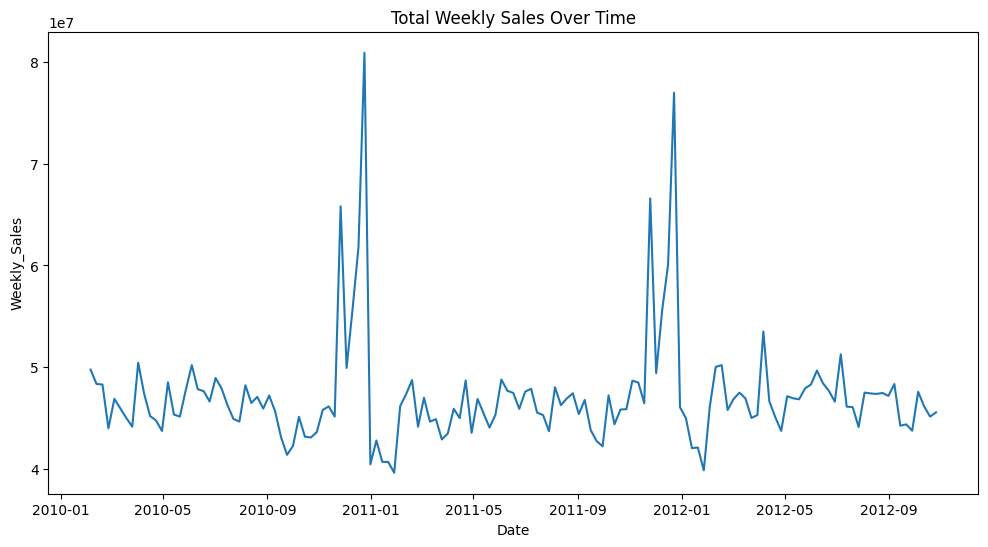

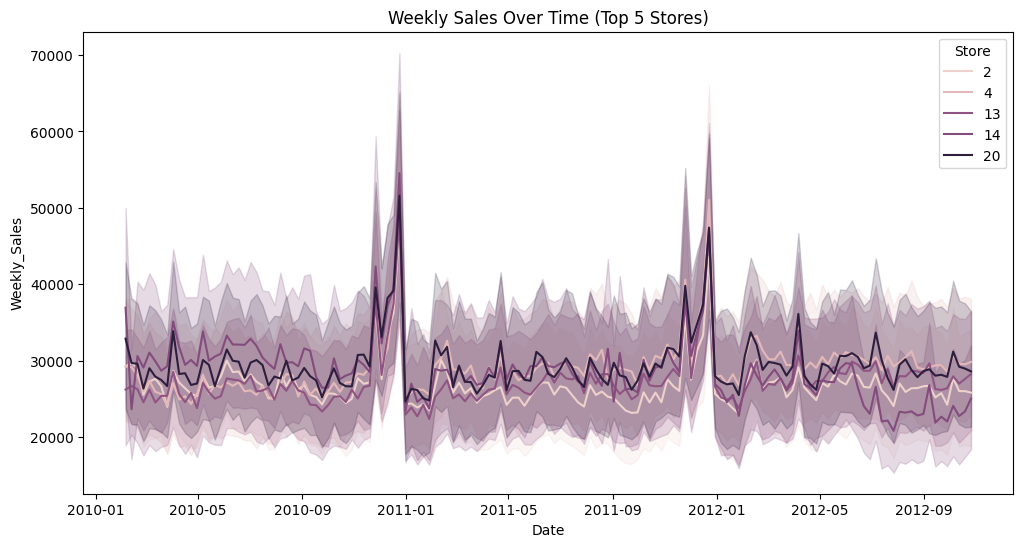

In [ ]:
# 📌 SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)

# Get top 5 stores by total sales
top_stores = merged.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index

# Filter data
top_store_data = merged[merged['Store'].isin(top_stores)]

# Total weekly sales
weekly_sales = merged.groupby("Date")["Weekly_Sales"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales, x="Date", y="Weekly_Sales")
plt.title("Total Weekly Sales Over Time")
plt.show()

import plotly.express as px

# Filter top stores
top_store_data = merged[merged['Store'].isin(top_stores)]

# Interactive line plot
fig = px.line(top_store_data, x="Date", y="Weekly_Sales", color="Store", title="Weekly Sales (Top Stores)")
fig.show()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_store_data, x="Date", y="Weekly_Sales", hue="Store")
plt.title("Weekly Sales Over Time (Top 5 Stores)")
plt.show()

# Weekly Sales Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged, x="Date", y="Weekly_Sales", hue="Store", legend=False)
plt.title("Weekly Sales Over Time")
plt.show()

# Sales by Store Type
plt.figure(figsize=(8, 5))
sns.boxplot(x="Type", y="Weekly_Sales", data=merged)
plt.title("Sales by Store Type")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = merged.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# 📌 SECTION 4: MODEL TRAINING & EVALUATION - RANDOM FOREST
!pip install -U scikit-learn

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

print("Random Forest R²:", r2_score(y_test, y_pred_rf))

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
print("Random Forest RMSE:", rmse)


Random Forest R²: 0.07502911794518863
Random Forest RMSE: 21962.365178826694


In [ ]:
# 📌 SECTION 5: LINEAR REGRESSION

print("Linear Regression R²:", r2_score(y_test_lr, y_pred_lr))

mse = mean_squared_error(y_test_lr, y_pred_lr)
rmse = np.sqrt(mse)
print("Linear Regression RMSE:", rmse)



Linear Regression R²: 0.06470911521829437
Linear Regression RMSE: 22084.54360670906


In [ ]:
print("Best XGBoost Params:", grid_search.best_params_)
print("XGBoost R²:", r2_score(y_test_xgb, y_pred_xgb))

mse = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse = np.sqrt(mse)
print("XGBoost RMSE:", rmse)


Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
XGBoost R²: 0.09670465624069757
XGBoost RMSE: 21703.509388392016


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train_xgb, y_train_xgb)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_xgb)

print("Best XGBoost Params:", grid_search.best_params_)
print("XGBoost R²:", r2_score(y_test_xgb, y_pred_xgb))

mse = mean_squared_error(y_test_xgb, y_pred_xgb)
rmse = np.sqrt(mse)
print("XGBoost RMSE:", rmse)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
XGBoost R²: 0.09670465624069757
XGBoost RMSE: 21703.509388392016


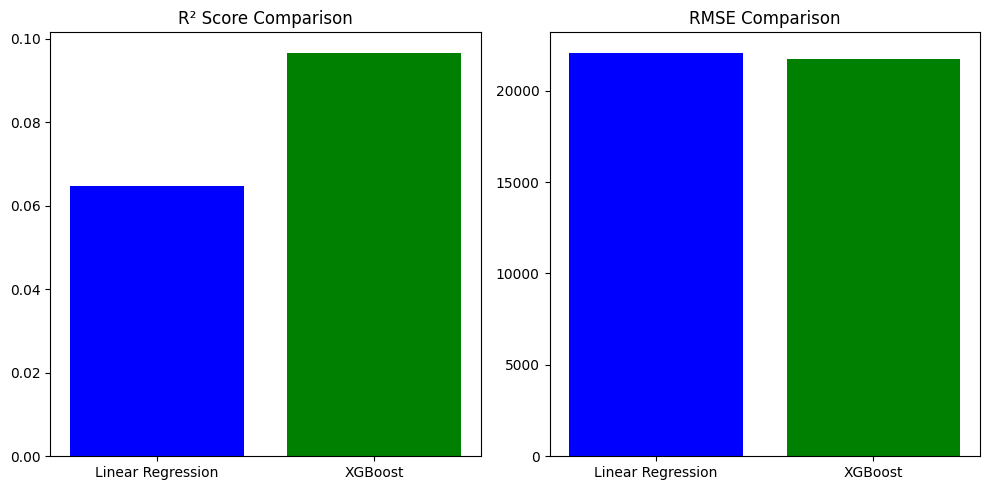

In [ ]:
# 📌 SECTION 7: COMPARISON VISUALIZATION

models = ['Linear Regression', 'XGBoost']
r2_scores = [r2_score(y_test_lr, y_pred_lr), r2_score(y_test_xgb, y_pred_xgb)]

# Calculate RMSE manually
rmse_scores = [
    np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
]

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color=['blue', 'green'])
plt.title('R² Score Comparison')

plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color=['blue', 'green'])
plt.title('RMSE Comparison')

plt.tight_layout()
plt.show()

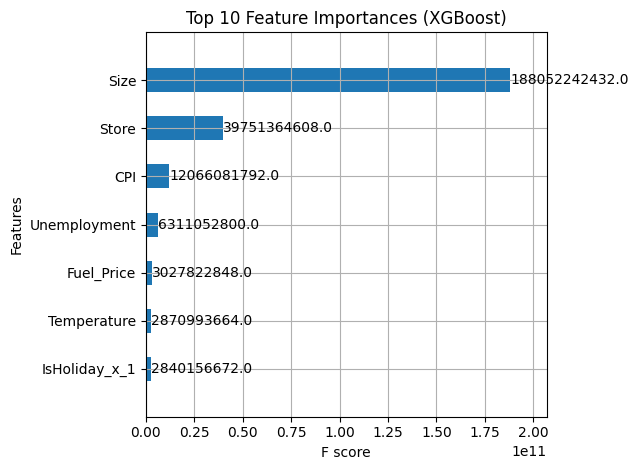

In [ ]:
# 📌 SECTION 8: FEATURE IMPORTANCE (XGBoost)
xgb.plot_importance(best_xgb, height=0.5, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [ ]:
# 📌 SECTION 9: ANOMALY DETECTION
merged['z_score'] = (merged['Weekly_Sales'] - merged['Weekly_Sales'].mean()) / merged['Weekly_Sales'].std()
merged['anomaly'] = merged['z_score'].apply(lambda z: 1 if np.abs(z) > 3 else 0)

anomalies = merged[merged['anomaly'] == 1]
print(f"🔍 Detected {len(anomalies)} anomalies in sales data.")
anomalies.to_csv("anomalies_sales.csv", index=False)
print("\n",anomalies.head())


🔍 Detected 8848 anomalies in sales data.

       Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  \
618       1     5 2010-12-24      85676.09            0        52.33   
903       1     7 2010-12-17      96198.12            0        49.84   
904       1     7 2010-12-24     166697.72            0        52.33   
956       1     7 2011-12-23     119302.15            0        47.96   
5118      1    38 2010-02-05     115564.35            0        42.31   

      Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
618        2.886       0.00       0.00        0.0        0.0       0.00   
903        2.869       0.00       0.00        0.0        0.0       0.00   
904        2.886       0.00       0.00        0.0        0.0       0.00   
956        3.112    2725.36      40.48      634.7       24.9    2739.43   
5118       2.572       0.00       0.00        0.0        0.0       0.00   

             CPI  Unemployment  IsHoliday_y Type    Size   z_score  anoma

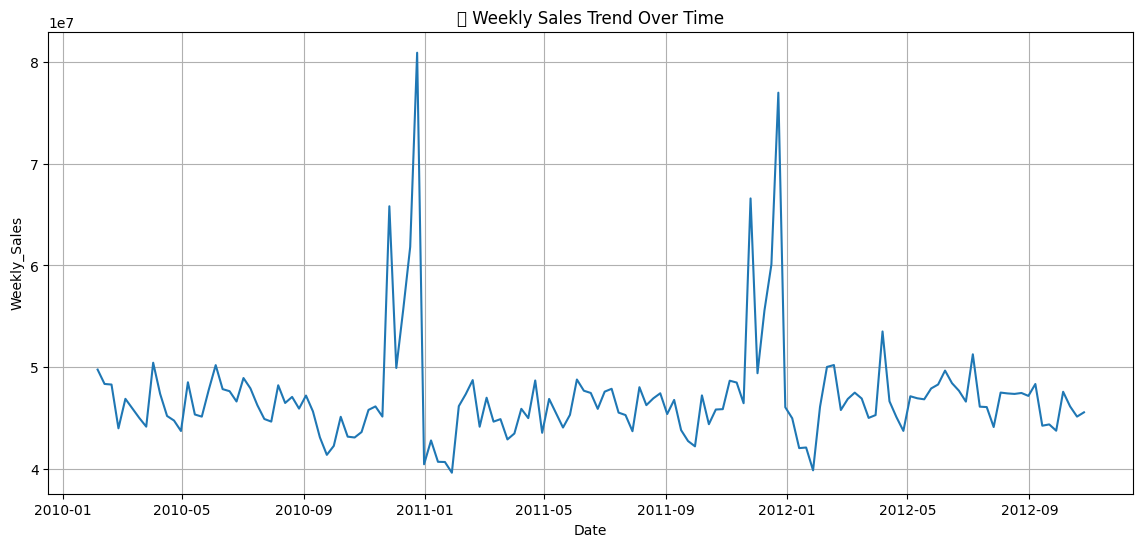

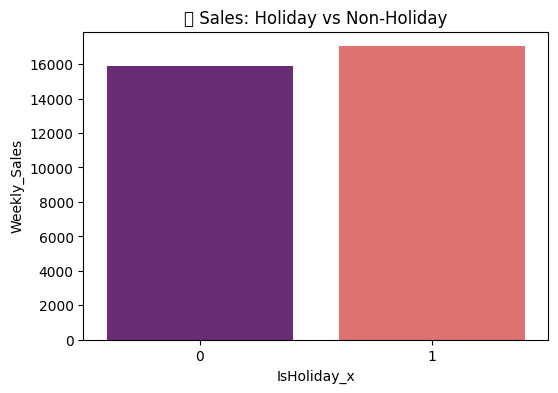

In [ ]:
# 📌 SECTION 10: SALES TREND & HOLIDAY ANALYSIS
weekly_sales = merged.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(x='Date', y='Weekly_Sales', data=weekly_sales)
plt.title("📈 Weekly Sales Trend Over Time")
plt.grid(True)
plt.show()

holiday_sales = merged.groupby('IsHoliday_x')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=holiday_sales, x='IsHoliday_x', y='Weekly_Sales', palette='magma')
plt.title("🎉 Sales: Holiday vs Non-Holiday")
plt.show()



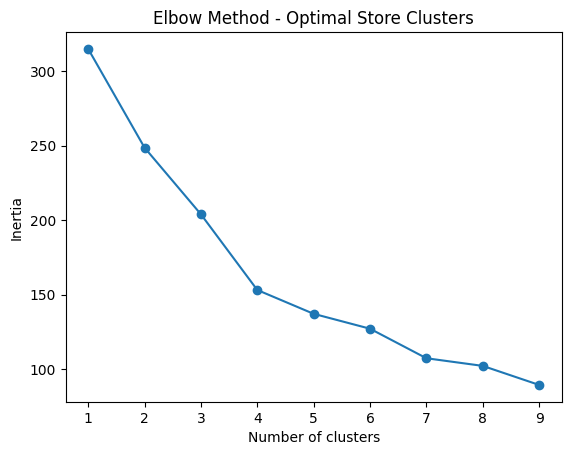

✅ Store segmentation done.


In [ ]:
# 📌 SECTION 11: STORE SEGMENTATION (KMeans)

store_df = merged.groupby('Store').agg({
    'Weekly_Sales': 'mean',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'IsHoliday_x': 'mean',  # Updated column name
    'Size': 'mean'
}).reset_index()


scaler = StandardScaler()
store_scaled = scaler.fit_transform(store_df.drop('Store', axis=1))

# Elbow method
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(store_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title("Elbow Method - Optimal Store Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
store_df['Cluster'] = kmeans.fit_predict(store_scaled)
store_df.to_csv("store_clusters.csv", index=False)
print("✅ Store segmentation done.")


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqgz93t_/za5s2izv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsqgz93t_/d3d3dqky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13864', 'data', 'file=/tmp/tmpsqgz93t_/za5s2izv.json', 'init=/tmp/tmpsqgz93t_/d3d3dqky.json', 'output', 'file=/tmp/tmpsqgz93t_/prophet_modelo23yesyw/prophet_model-20250601114049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:40:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


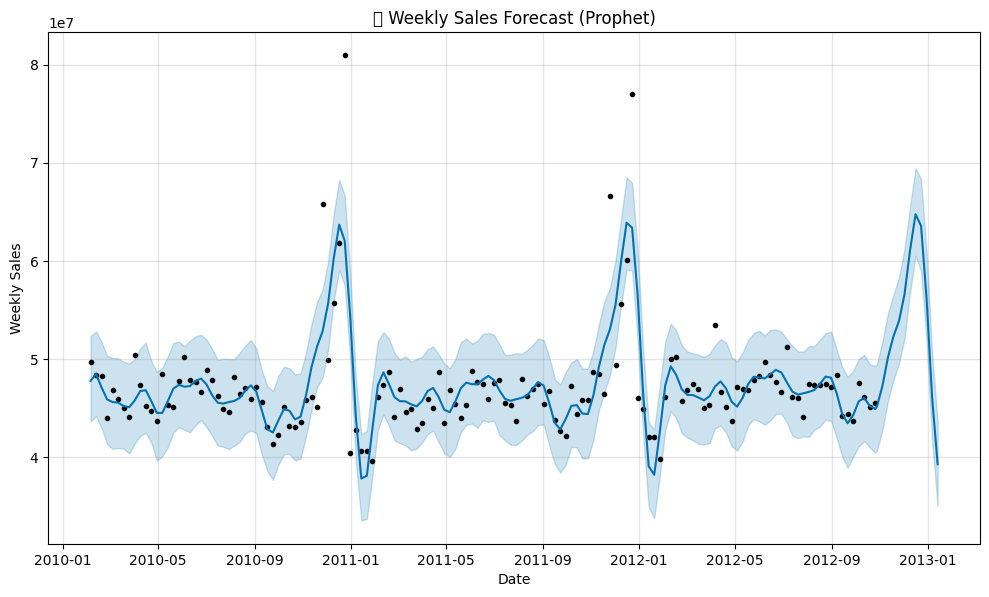

In [ ]:
# Rename columns as Prophet requires 'ds' (date) and 'y' (target)
ts_df = weekly_sales.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Initialize and fit the model
model = Prophet()
model.fit(ts_df)

# Create future dataframe with 12 weeks ahead
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("🔮 Weekly Sales Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

# Save forecast results to CSV
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("sales_forecast.csv", index=False)


In [ ]:
!pip install dash plotly statsmodels pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [ ]:
# Load your data here
# For example, using your merged dataframe previously loaded, or just weekly_sales csv:
# weekly_sales = pd.read_csv('weekly_sales.csv', parse_dates=['Date'])

# Example: Assuming you already have `weekly_sales` dataframe:
# If not, replace this with your actual loading logic:
weekly_sales = pd.read_csv("/content/merged_sales_data.csv", parse_dates=['Date'])
weekly_sales = weekly_sales.groupby("Date")["Weekly_Sales"].sum().reset_index()
weekly_sales_ts = weekly_sales.set_index('Date')

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_sales_ts['Weekly_Sales'], model='additive', period=52)

# Calculate rolling statistics
rolling_mean = weekly_sales_ts['Weekly_Sales'].rolling(window=12).mean()
rolling_std = weekly_sales_ts['Weekly_Sales'].rolling(window=12).std()

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Sales Time Series Dashboard"

app.layout = html.Div([
    html.H1("Weekly Sales Time Series Analysis Dashboard", style={'text-align': 'center'}),

    dcc.Graph(
        id='time-series-plot',
        figure={
            'data': [
                go.Scatter(x=weekly_sales_ts.index, y=weekly_sales_ts['Weekly_Sales'], mode='lines', name='Original Sales'),
                go.Scatter(x=rolling_mean.index, y=rolling_mean, mode='lines', name='Rolling Mean (12 weeks)'),
                go.Scatter(x=rolling_std.index, y=rolling_std, mode='lines', name='Rolling Std (12 weeks)')
            ],
            'layout': go.Layout(
                title='Weekly Sales with Rolling Mean & Std',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Weekly Sales'}
            )
        }
    ),

    html.H2("Seasonal Decomposition", style={'text-align': 'center'}),

    dcc.Tabs(id='decomposition-tabs', value='observed', children=[
        dcc.Tab(label='Observed', value='observed'),
        dcc.Tab(label='Trend', value='trend'),
        dcc.Tab(label='Seasonal', value='seasonal'),
        dcc.Tab(label='Residual', value='residual'),
    ]),

    dcc.Graph(id='decomposition-graph')
])

@app.callback(
    Output('decomposition-graph', 'figure'),
    Input('decomposition-tabs', 'value')
)
def update_decomposition(tab):
    if tab == 'observed':
        y = decomposition.observed
        title = 'Observed'
    elif tab == 'trend':
        y = decomposition.trend
        title = 'Trend'
    elif tab == 'seasonal':
        y = decomposition.seasonal
        title = 'Seasonal'
    elif tab == 'residual':
        y = decomposition.resid
        title = 'Residual'
    else:
        y = decomposition.observed
        title = 'Observed'

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=weekly_sales_ts.index, y=y, mode='lines', name=title))
    fig.update_layout(title=f'Seasonal Decomposition - {title}',
                      xaxis_title='Date',
                      yaxis_title='Value')
    return fig

if __name__ == '__main__':
    app.run(debug=True)



<IPython.core.display.Javascript object>

In [ ]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objs as go

app = Dash(__name__)

# Preload data for dashboard
store_options = [{'label': f'Store {s}', 'value': s} for s in merged['Store'].unique()]

app.layout = html.Div([
    dcc.Tabs([
        dcc.Tab(label='Store Sales Overview', children=[
            dcc.Dropdown(id='store-dropdown', options=store_options, value=store_options[0]['value']),
            dcc.Graph(id='store-sales-graph')
        ]),
        dcc.Tab(label='STL Decomposition', children=[
            dcc.Graph(id='stl-graph')
        ]),
        dcc.Tab(label='ARIMA Forecast', children=[
            dcc.Graph(id='arima-forecast-graph')
        ]),
        dcc.Tab(label='Anomaly Explorer', children=[
            dcc.Dropdown(
                id='anomaly-store-dropdown',
                options=store_options,
                value=store_options[0]['value']
            ),
            dcc.Graph(id='anomaly-graph')
        ])
    ])
])

# Callback for Store Sales Overview
@app.callback(
    Output('store-sales-graph', 'figure'),
    Input('store-dropdown', 'value')
)
def update_store_sales(store_id):
    df = merged[merged['Store'] == store_id].sort_values('Date')
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Weekly_Sales'], mode='lines+markers', name='Sales'))
    fig.update_layout(title=f"Weekly Sales for Store {store_id}", xaxis_title='Date', yaxis_title='Weekly Sales')
    return fig

# Callback for STL Decomposition plot
@app.callback(
    Output('stl-graph', 'figure'),
    Input('store-dropdown', 'value')  # optionally add input to select store or use overall sales
)
def update_stl(store_id):
    # Example uses overall weekly_sales, could be adapted per store
    series = weekly_sales['Weekly_Sales']
    stl = STL(series, seasonal=13)
    res = stl.fit()

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                        subplot_titles=['Observed', 'Trend', 'Seasonal'])
    fig.add_trace(go.Scatter(x=series.index, y=res.observed, name='Observed'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series.index, y=res.trend, name='Trend'), row=2, col=1)
    fig.add_trace(go.Scatter(x=series.index, y=res.seasonal, name='Seasonal'), row=3, col=1)
    fig.update_layout(height=600, title_text="STL Decomposition")
    return fig

# Callback for ARIMA forecast plot
@app.callback(
    Output('arima-forecast-graph', 'figure'),
    Input('store-dropdown', 'value')
)
def update_arima(store_id):
    # Use precomputed forecast_df from above or recompute here for selected store
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=weekly_sales.index, y=weekly_sales['Weekly_Sales'], mode='lines', name='Historical'))
    fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['yhat'], mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(
        x=pd.concat([forecast_df['ds'], forecast_df['ds'][::-1]]),
        y=pd.concat([forecast_df['yhat_upper'], forecast_df['yhat_lower'][::-1]]),
        fill='toself',
        fillcolor='rgba(255, 182, 193, 0.3)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))
    fig.update_layout(title='ARIMA Forecast', xaxis_title='Date', yaxis_title='Weekly Sales')
    return fig

# Callback for Anomaly Explorer
@app.callback(
    Output('anomaly-graph', 'figure'),
    Input('anomaly-store-dropdown', 'value')
)
def update_anomaly(store_id):
    df = merged[merged['Store'] == store_id].sort_values('Date')
    anomalies = df[df['anomaly'] == 1]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Weekly_Sales'], mode='lines', name='Sales'))
    fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['Weekly_Sales'], mode='markers',
                             marker=dict(color='red', size=10), name='Anomalies'))
    fig.update_layout(title=f'Sales and Anomalies for Store {store_id}', xaxis_title='Date', yaxis_title='Weekly Sales')
    return fig


if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
weekly_sales = merged.groupby('Date')['Weekly_Sales'].sum().reset_index()
print(weekly_sales.columns)


Index(['Date', 'Weekly_Sales'], dtype='object')


In [ ]:
weekly_sales = weekly_sales.sort_values('Date').set_index('Date')


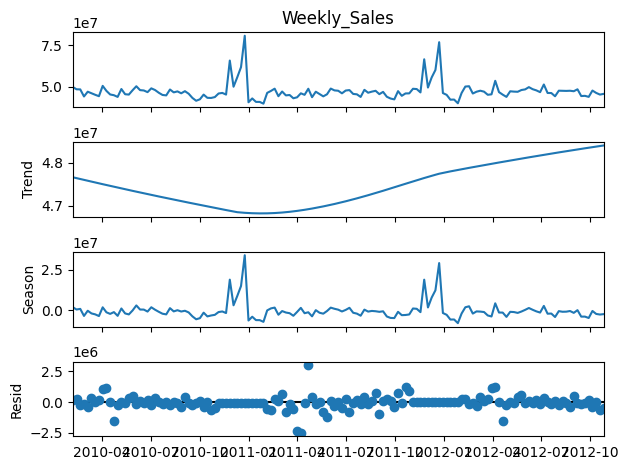

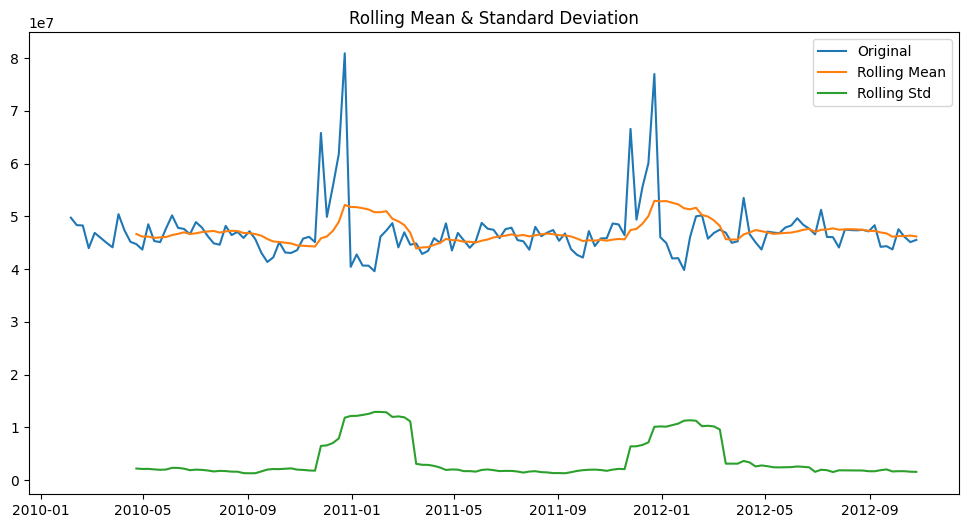

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(weekly_sales['Weekly_Sales'], seasonal=13)
result = stl.fit()

# Plot STL components
result.plot()
plt.show()

# Rolling statistics
rolling_mean = weekly_sales['Weekly_Sales'].rolling(window=12).mean()
rolling_std = weekly_sales['Weekly_Sales'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(weekly_sales['Weekly_Sales'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()
